In [49]:
%pip install kmodes --quiet
%pip install gower --quiet
%pip install optuna --quiet
%pip install gower validclust --quiet
%pip install scikit-learn-extra --quiet
%pip install plotly --quiet


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip available: 22.3 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip available: 22.3 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip available: 22.3 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip available: 22.3 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip available: 22.3 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip available: 22.3 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [50]:
import warnings
warnings.filterwarnings(
    "ignore",
    category=DeprecationWarning,
    message=".*datetime.datetime.utcnow.*"
)


In [51]:
import numpy as np
from kmodes.kprototypes import KPrototypes
import pandas as pd
import ast
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.inspection import permutation_importance
from xgboost import XGBClassifier
import shap
from sklearn.tree import DecisionTreeClassifier, export_text
import pandas as pd
import gower
from sklearn.metrics import silhouette_score
from sklearn.model_selection import ParameterGrid
import optuna
from sklearn.metrics import silhouette_score, davies_bouldin_score
from validclust import dunn
import matplotlib.cm as cm
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots


In [52]:
## Load Data
df = pd.read_csv('../data/tropical_cyclones_records__p.csv')
df.head()

,typhoon_name,year,region,province,city_municipality,families,person,brgy,dead,injured_ill,missing,totally,partially,total,cost,has_food,has_cash,has_hygiene_health,has_sleeping_essentials,has_shelter_support
0,AGATON,2022,8,LEYTE,ABUYOG,18957.0,68354.0,63.0,55.0,0.0,0.0,142.0,326.0,468.0,13172269.32,1,0,1,1,0
1,AGATON,2022,6,ILOILO,AJUY,17414.0,61983.0,34.0,1.0,0.0,0.0,236.0,856.0,1092.0,2948690.00,1,1,1,1,0
2,AGATON,2022,8,LEYTE,ALANGALANG,1323.0,5444.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,46740.00,1,0,0,0,0
3,AGATON,2022,8,LEYTE,ALBUERA,203.0,1008.0,0.0,0.0,0.0,0.0,5.0,0.0,5.0,0.00,0,0,0,0,0
4,AGATON,2022,8,BILIRAN,ALMERIA,125.0,488.0,11.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0,0,0,0,0


### 2.1 Transformation from Event-Based to Province-Based Data

*   Create a composite ID = ```(province, region)```

Aggregate data by composite ID:
* Sum ```(families, person, dead, injured_ill, missing, totally, partially, cost)```
* Sum ```(has_food, has_cash, has_hygiene_health, has_sleeping_essentials, has_shelter_support)```
* Count Number of typhoon events using nunique
* First and last year for recurrence rate, year min max







In [53]:
# --- Step 1. Clean and prepare typhoon names ---
df['typhoon_name_clean'] = df['typhoon_name'].str.strip()

# Create exploded version for individual typhoons
df['typhoon_list'] = df['typhoon_name_clean'].str.split('-')
df_exploded = df.explode('typhoon_list')
df_exploded['typhoon_list'] = df_exploded['typhoon_list'].str.strip()

# --- Step 2. Aggregation dictionary (without typhoon_name nunique here) ---
agg_dict = {
    # Impact & Damage (sum)
    'families': 'sum',
    'person': 'sum',
    'dead': 'sum',
    'injured_ill': 'sum',
    'missing': 'sum',
    'totally': 'sum',
    'partially': 'sum',
    'cost': 'sum',

    # Aid flags (mean across events)
    'has_food': 'sum',
    'has_cash': 'sum',
    'has_hygiene_health': 'sum',
    'has_sleeping_essentials': 'sum',
    'has_shelter_support': 'sum',

    # First and last year for recurrence rate
    'year': ['min', 'max'],
}

# --- Step 3. Province-level aggregation for impact & aid ---
province_df = df.groupby(['province', 'region']).agg(agg_dict).reset_index()

# Flatten column names after multi-level aggregation
province_df.columns = ['_'.join(col).strip() if isinstance(col, tuple) else col for col in province_df.columns]
province_df = province_df.rename(columns={
    'province': 'province_',
    'region': 'region_',
    'year_min': 'first_year',
    'year_max': 'last_year'
})

# --- Step 4. Province-level typhoon counts ---

# (a) Count unique report names (original merged names)
province_reports = (
    df.groupby(['province', 'region'])
      .agg({'typhoon_name_clean': 'nunique'})
      .reset_index()
      .rename(columns={'typhoon_name_clean': 'num_reports'})
)

# (b) Count unique individual typhoons (after split/explode)
province_typhoons = (
    df_exploded.groupby(['province', 'region'])
               .agg({'typhoon_list': 'nunique'})
               .reset_index()
               .rename(columns={'typhoon_list': 'num_typhoons'})
)

# --- Step 5. Merge into final province_df ---
province_df = (
    province_df
    .merge(province_reports, left_on=['province_', 'region_'], right_on=['province', 'region'], how='left')
    .merge(province_typhoons, left_on=['province_', 'region_'], right_on=['province', 'region'], how='left')
    .drop(columns=['province_x', 'region_x', 'province_y', 'region_y'])
)


In [54]:
province_df['region_'].value_counts()

region_
3         8
BARMM     8
5         7
6         7
CAR       6
CARAGA    6
8         6
11        6
2         5
4A        5
10        5
9         5
1         5
4B        5
7         4
12        4
NCR       1
Name: count, dtype: int64

### 2.2 Derived Features

*   new column for ```recurrence_rate``` = num of typhoons / (last year - first year + 1)
*   new column for ```cost_per_family``` = cost_sum / families_sum[link text](https://)



In [55]:
province_df['recurrence_rate'] = province_df['num_typhoons'] / (
    province_df['last_year'] - province_df['first_year'] + 1
)

In [56]:
province_df['cost_per_family'] = province_df.apply(
    lambda row: row['cost_sum'] / row['families_sum'] if row['families_sum'] > 0 else np.nan,
    axis=1
)

In [57]:
province_df.isnull().sum()

province_                      0
region_                        0
families_sum                   0
person_sum                     0
dead_sum                       0
injured_ill_sum                0
missing_sum                    0
totally_sum                    0
partially_sum                  0
cost_sum                       0
has_food_sum                   0
has_cash_sum                   0
has_hygiene_health_sum         0
has_sleeping_essentials_sum    0
has_shelter_support_sum        0
first_year                     0
last_year                      0
num_reports                    0
num_typhoons                   0
recurrence_rate                0
cost_per_family                0
dtype: int64

## Feature Selection
Building correlation matrix and removing
```families_sum, first_year, last_year, total```

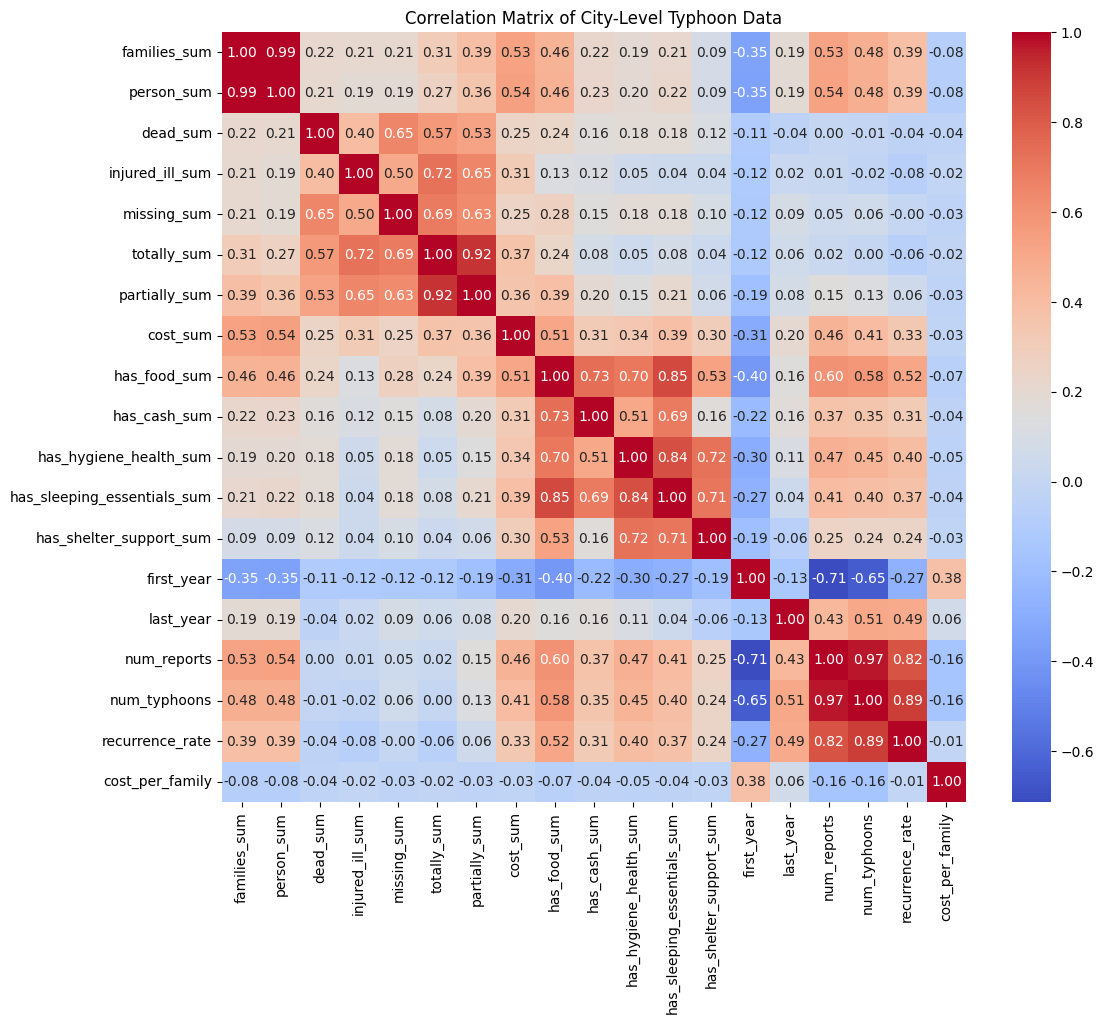

In [58]:
correlation_matrix = province_df.corr(numeric_only=True)

plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix of City-Level Typhoon Data')
plt.show()

In [59]:
province_df.to_csv('../data/tropical_cyclones_records_standard.csv', index=False)

In [60]:
province_df.drop(['families_sum', 'first_year', 'last_year', 'num_reports'], axis=1, inplace=True)


#### Changing the index to province + region

In [61]:
# # Create a unique province-region ID
# province_df['province_region'] = province_df['province_'] + ' (' + province_df['region_'] + ')'

# # Set it as index (optional but clean)
# province_df.set_index('province_region', inplace=True)

# # Now drop the original 'province_' column
# province_df.drop(columns=['province_'], inplace=True)

In [62]:
province_df.columns

Index(['province_', 'region_', 'person_sum', 'dead_sum', 'injured_ill_sum',
       'missing_sum', 'totally_sum', 'partially_sum', 'cost_sum',
       'has_food_sum', 'has_cash_sum', 'has_hygiene_health_sum',
       'has_sleeping_essentials_sum', 'has_shelter_support_sum',
       'num_typhoons', 'recurrence_rate', 'cost_per_family'],
      dtype='object')

In [63]:
province_df.head()

,province_,region_,person_sum,dead_sum,injured_ill_sum,missing_sum,totally_sum,partially_sum,cost_sum,has_food_sum,has_cash_sum,has_hygiene_health_sum,has_sleeping_essentials_sum,has_shelter_support_sum,num_typhoons,recurrence_rate,cost_per_family
0,ABRA,CAR,665436.0,2.0,115.0,0.0,58.0,888.0,2.946309e+07,61,46,8,4,4,29,5.800000,154.257011
1,AGUSAN DEL NORTE,CARAGA,189625.0,0.0,0.0,0.0,2876.0,9376.0,2.032942e+07,1,0,0,0,0,9,1.800000,451.313549
2,AGUSAN DEL SUR,CARAGA,221391.0,0.0,0.0,0.0,167.0,707.0,6.707485e+06,3,0,0,0,0,5,1.250000,120.374087
3,AKLAN,6,637351.0,8.0,2.0,1.0,273.0,9530.0,6.632630e+07,51,35,1,3,0,22,4.400000,388.050105
4,ALBAY,5,2402839.0,6.0,7.0,0.0,19277.0,105509.0,1.531597e+08,52,2,5,6,8,25,4.166667,246.731259


In [64]:
province_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 93 entries, 0 to 92
Data columns (total 17 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   province_                    93 non-null     object 
 1   region_                      93 non-null     object 
 2   person_sum                   93 non-null     float64
 3   dead_sum                     93 non-null     float64
 4   injured_ill_sum              93 non-null     float64
 5   missing_sum                  93 non-null     float64
 6   totally_sum                  93 non-null     float64
 7   partially_sum                93 non-null     float64
 8   cost_sum                     93 non-null     float64
 9   has_food_sum                 93 non-null     int64  
 10  has_cash_sum                 93 non-null     int64  
 11  has_hygiene_health_sum       93 non-null     int64  
 12  has_sleeping_essentials_sum  93 non-null     int64  
 13  has_shelter_support_su

In [ ]:
province_df.to_csv('../data/tropical_cyclones_records_f.csv', index=False)